# Chlorophyll

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import os
import os.path as op
import sys

import pandas as pd
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_int import plot_timeseries_interactive
from ind_setup.plotting import plot_base_map, plot_map_subplots
from ind_setup.core import fontsize

sys.path.append("../../../functions")
from data_downloaders import download_ERDDAP_data


Define area of interest

In [2]:
#Area of interest
lon_range  = [129.4088, 137.0541]
lat_range = [1.5214, 11.6587]

EEZ shapefile

In [3]:
shp_f = op.join(os.getcwd(), '..', '..','..', 'data/Palau_EEZ/pw_eez_pol_april2022.shp')
shp_eez = gpd.read_file(shp_f)

## Download Data

In [4]:
base_url = 'https://oceanwatch.pifsc.noaa.gov/erddap/griddap/esa-cci-chla-monthly-v6-0.csv'
dataset_id = 'chlor_a'
date_ini = '1998-01-01T00:00:00Z'
date_end = '2023-12-01T00:00:00Z'

data = download_ERDDAP_data(base_url, dataset_id, date_ini, date_end, lon_range, lat_range)

/Users/laurac/Documents/HAWAII/repository_GItHub/CC_indicators/notebooks_historical/ocean/3_biochemistry/../../../functions/data_downloaders.py:266: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(url).iloc[1:].reset_index(drop=True)


In [7]:
data_xr = data.set_index(['latitude', 'longitude', 'time']).to_xarray()
data_xr['time'] = pd.to_datetime(data_xr.time)
data_xr = data_xr.coarsen(longitude=2, latitude=2, boundary = 'pad').mean()

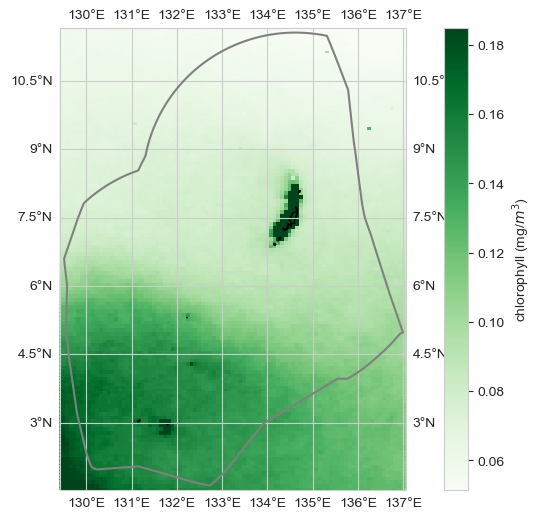

In [30]:
ax = plot_base_map(shp_eez = shp_eez, figsize = [10, 6])
im = ax.pcolor(data_xr.longitude, data_xr.latitude, data_xr.mean(dim='time')[dataset_id], transform=ccrs.PlateCarree(), 
                cmap = 'Greens', vmin = np.percentile(data_xr.mean(dim = 'time')[dataset_id], 1), 
                vmax = np.percentile(data_xr.mean(dim = 'time')[dataset_id], 99))
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
plt.colorbar(im, ax=ax, label='chlorophyll (mg/$m^3$)')


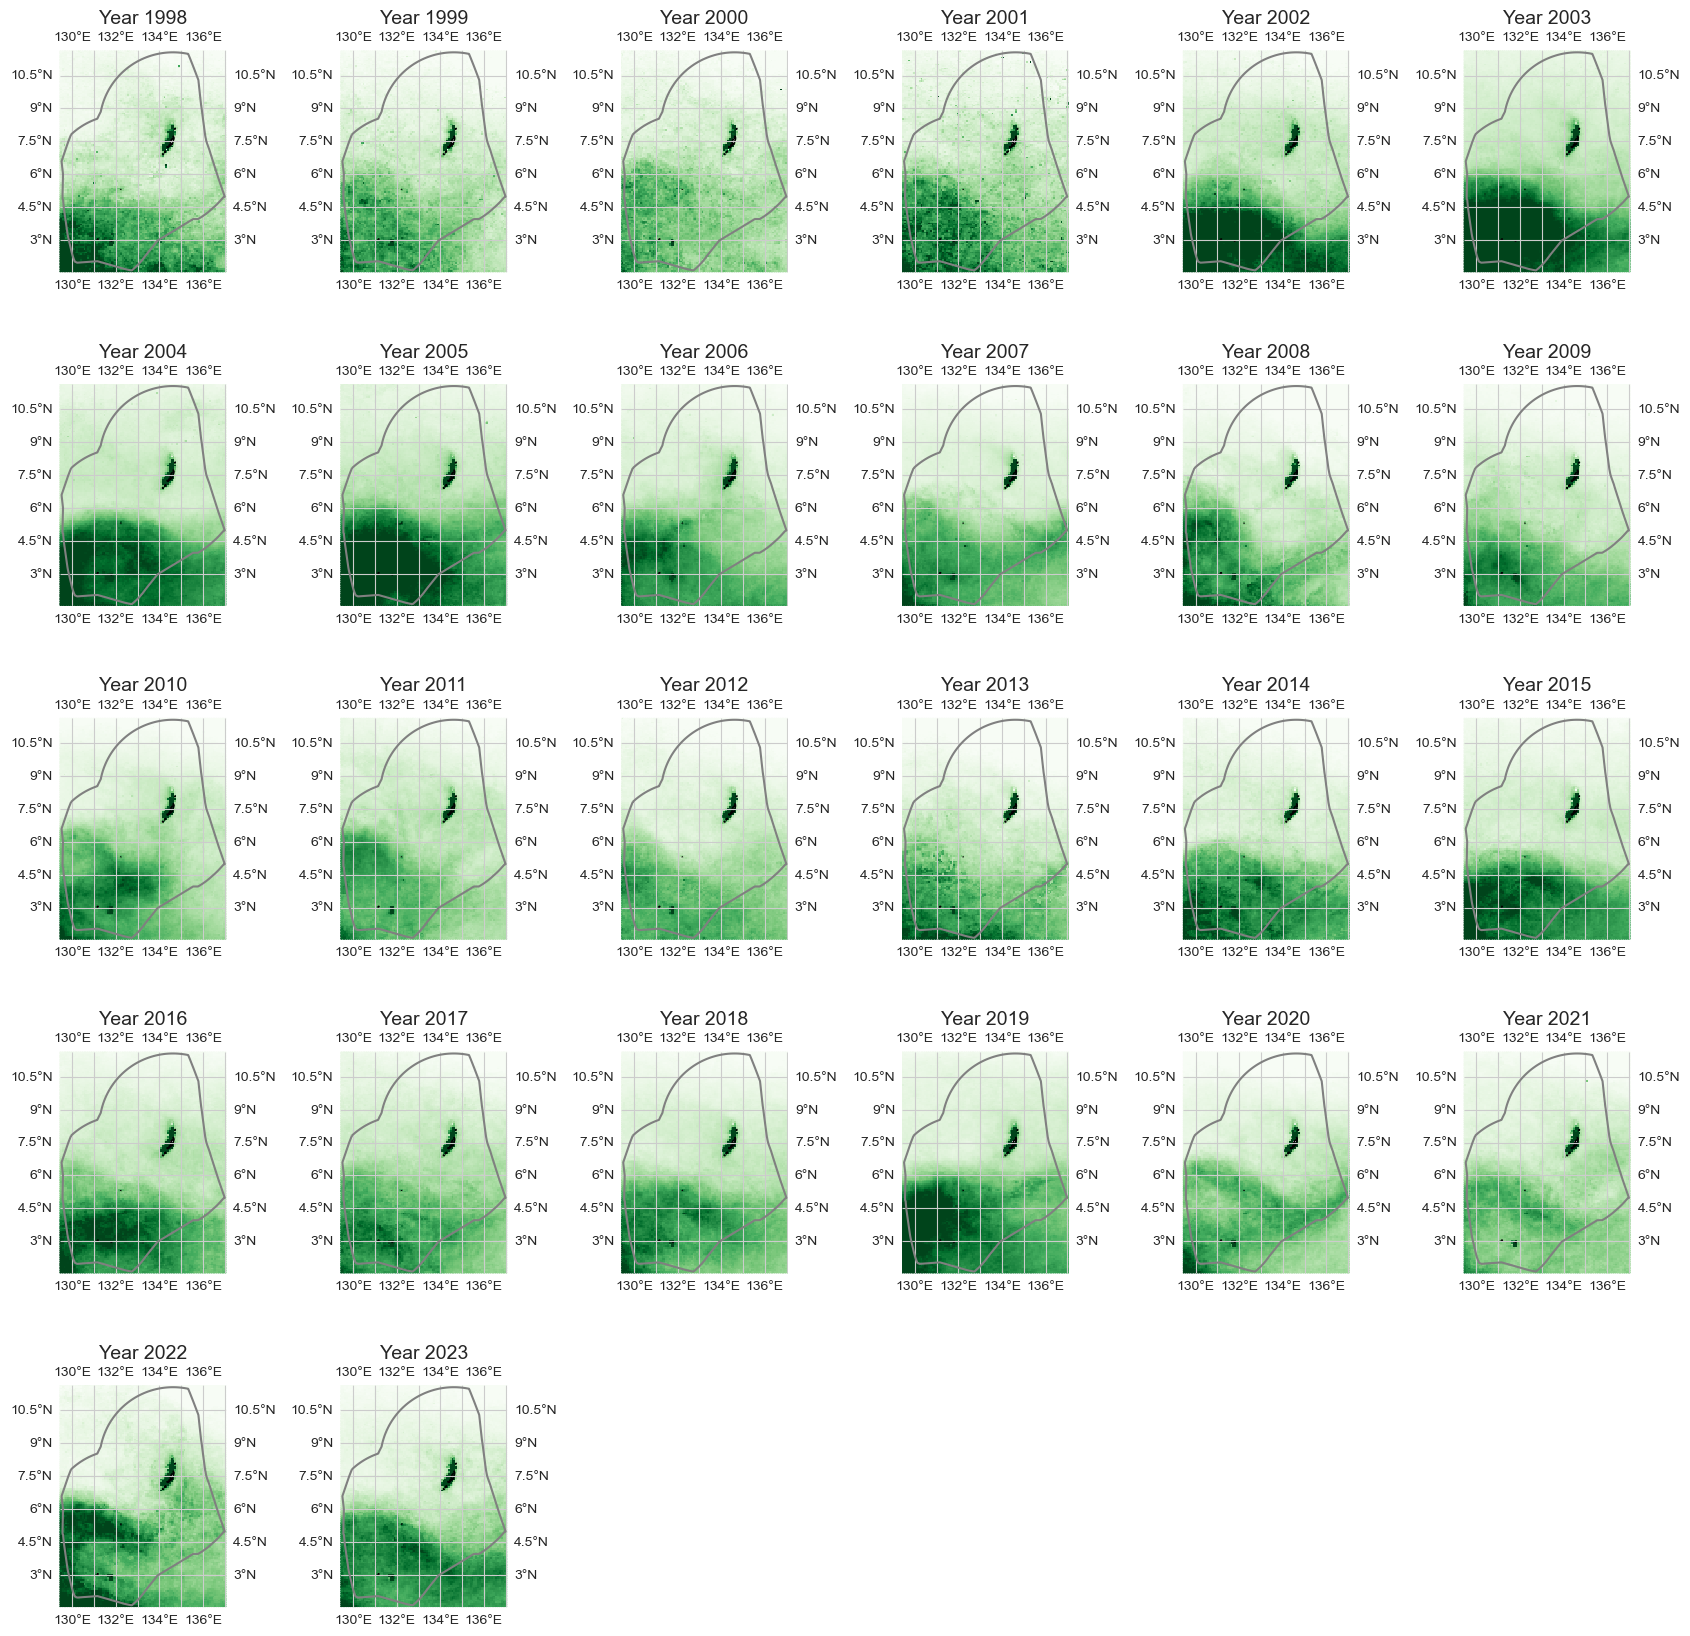

In [31]:
data_y = data_xr.resample(time='1YE').mean()
plot_map_subplots(data_y, dataset_id, shp_eez = shp_eez, cmap = 'Greens', vmin = np.percentile(data_xr.mean(dim = 'time')[dataset_id], 1), 
                vmax = np.percentile(data_xr.mean(dim = 'time')[dataset_id], 99))

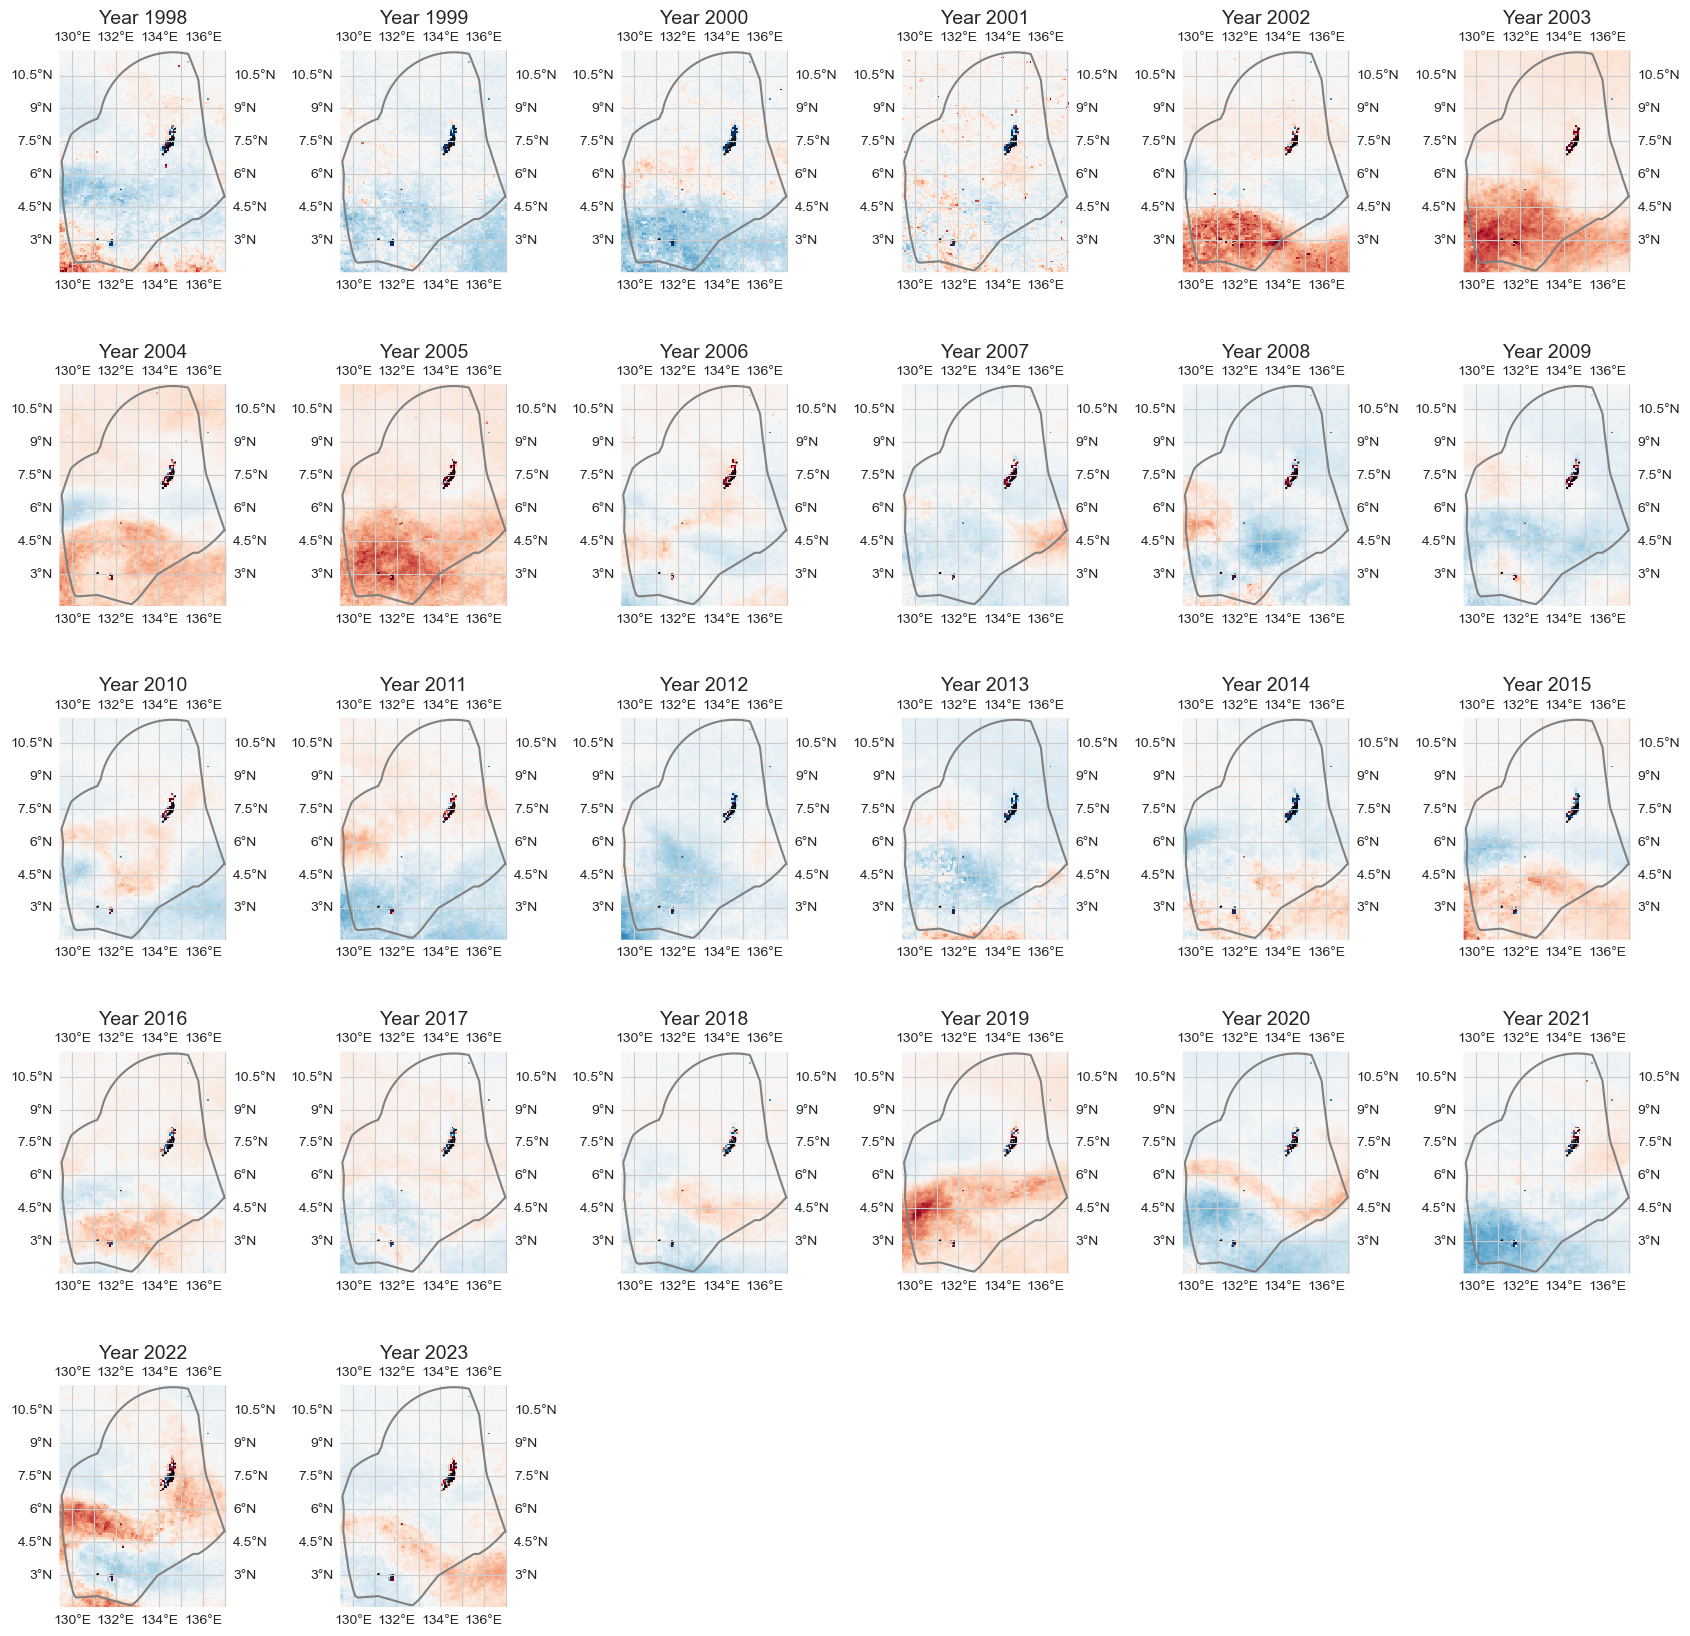

In [32]:
data_an = data_y - data_xr.mean(dim='time')
plot_map_subplots(data_an, dataset_id, shp_eez = shp_eez, cmap='RdBu_r', vmin=-.1, vmax=.1)

## Mean Area

In [37]:
dict_plot = [{'data' : data_xr.mean(dim = ['longitude', 'latitude']).to_dataframe(), 
              'var' : dataset_id, 'ax' : 1, 'label' : 'Chlorophyll - MEAN AREA'},]

In [38]:
fig = plot_timeseries_interactive(dict_plot, trendline=True, scatter_dict = None);

## Given point

In [50]:
loc = [7.37, 134.7]
dict_plot = [{'data' : data_xr.sel(longitude=loc[1], latitude=loc[0], method='nearest').to_dataframe(), 
              'var' : dataset_id, 'ax' : 1, 'label' : f'Chlorophyll at [{loc[0]}, {loc[1]}]'},]

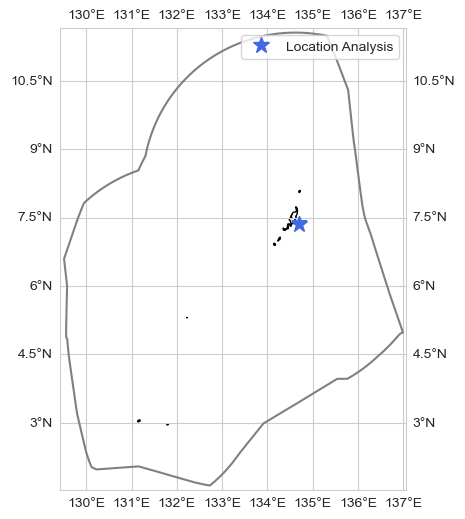

In [60]:
ax = plot_base_map(shp_eez = shp_eez, figsize = [10, 6])
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())
ax.plot(loc[1], loc[0], '*', markersize = 12, color = 'royalblue', transform=ccrs.PlateCarree(), label = 'Location Analysis')
ax.legend()

In [61]:
fig = plot_timeseries_interactive(dict_plot, trendline=True, scatter_dict = None);